In [1]:
import cv2
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
from IPython.display import display, Image, clear_output
from PIL import Image as PILImage
import io
from multiprocessing import Process, Queue, Lock
from concurrent.futures import ProcessPoolExecutor
import threading
import queue

In [2]:
model_path = r'A:\AI DB\LSPD\models\MultiModalUnfreezeLa5er.keras'
model_path2 = r'A:\AI DB\LSPD\models\MultiModalUnfreeze96.keras'
model_path3= r'A:\AI DB\LSPD\models\3ModaforImagesFromVideosV2.keras'
#image_model = load_model(model_path)
#image_model2 = load_model(model_path2)
model_best = load_model(model_path3)

In [3]:
# Directory containing videos with pornographic content
normal_video_directory = r'A:\AI DB\NPDI-2K\original\nonPorn'

# Directory containing normal videos
porn_video_directory = r'A:\AI DB\NPDI-2K\original\porn'

In [3]:
def preprocess_frame(frame):
    # Resize the frame to 224x224
    resized_frame = cv2.resize(frame, (224, 224))
    # Convert the frame to RGB (if it's in BGR)
    if resized_frame.shape[2] == 3:
        resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    # Convert the frame to a format suitable for MobileNetV2
    processed_frame = resized_frame / 255.0
    # Add batch dimension
    processed_frame = np.expand_dims(processed_frame, axis=0)
    return processed_frame

In [6]:
a=classify_video_images(r'A:\AI DB\LSPD_test_videosSplited\porn\porn_208.mp4',model_best,sensibility=0.9)
print(a)

Total time: 2.81 seconds.
Percentage of pornographic frames: 105.51%
[(0.0, 30.96)]


In [11]:
def classify_video_images(video_path, model, interval=1, void_threshold=1, sensibility=0.5700000000000001, threshold=0.1, x=''):
    start_time = time.time()
    
    # Open the video file
    video_capture = cv2.VideoCapture(video_path)
    
    # Get the frame rate and total frame count of the video
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the total duration of the video in seconds
    total_duration = total_frames / fps
    
    # Calculate the frame interval based on the desired interval
    frame_interval = int(fps * interval)
    
    # Initialize a list to store timestamps where pornographic content is detected
    porn_detected_timestamps = []
    
    # Loop through the video frames
    porn_frame_count = 0
    for frame_count in range(0, total_frames, frame_interval):
        # Set the position of the next frame to read
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
        
        # Read the next frame
        ret, frame = video_capture.read()
        
        # Check if the frame was read successfully
        if not ret:
            break

        processed_frame = preprocess_frame(frame)
        # Classify the frame using the model
        # Replace this line with your actual classification code
        is_porn = model.predict(processed_frame, verbose=0)
        
        # If pornographic content is detected, record the timestamp and display the image
        if is_porn >= sensibility:
            timestamp = (round(frame_count / fps,2)   ,   round((frame_count+frame_interval) / fps,2))
            porn_detected_timestamps.append(timestamp)
                        
            # Increment the count of pornographic frames
            porn_frame_count += 1
        
        # Update and print progress
        progress_percentage = (frame_count / total_frames) * 100
        clear_output(wait=True)
        print(x)
        print(f"        Processing frame {frame_count}/{total_frames} ({progress_percentage:.2f}%)")

    # Release the video capture object
    video_capture.release()
    #print(porn_detected_timestamps)
    # Calculate the ratio of pornographic frames to the total number of frames
    porn_frame_ratio = (porn_frame_count / (total_frames / frame_interval)) * 100
    
    # Check if the ratio is below the threshold or if only two frames are detected as pornographic
    if porn_frame_ratio < threshold or porn_frame_count <= 2:
        elapsed_time = time.time() - start_time
        clear_output(wait=True)  # Clear the final progress
        print(f"Total time: {elapsed_time:.2f} seconds.")
        print("Percentage of pornographic frames: 0.00%")
        return []
    print('porn detected timestamps',porn_detected_timestamps)
    # Smooth and merge consecutive intervals
    smoothed_timestamps = []
    current_interval_start = None
        
    for start, end in porn_detected_timestamps:
        if current_interval_start is None:
            current_interval_start = start
            current_interval_end = end
        elif start - current_interval_end <= void_threshold:
                # Merge with the current interval
            current_interval_end = max(current_interval_end, end)
        else:
                # Add the current interval to smoothed_timestamps
            smoothed_timestamps.append((current_interval_start, current_interval_end))
                # Start a new interval
            current_interval_start = start
            current_interval_end = end
        
        # Add the last interval if it exists
    if current_interval_start is not None:
        smoothed_timestamps.append((current_interval_start, current_interval_end))

    elapsed_time = time.time() - start_time
    clear_output(wait=True)  # Clear the final progress
    print(f"Total time: {elapsed_time:.2f} seconds.")
    print(f"Percentage of pornographic frames: {porn_frame_ratio:.2f}%")
    
    return smoothed_timestamps

In [4]:
#faster
def frame_reader(video_path, frame_queue, interval, fps, total_frames):
    video_capture = cv2.VideoCapture(video_path)
    frame_interval = int(fps * interval)
    
    for frame_count in range(0, total_frames, frame_interval):
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
        ret, frame = video_capture.read()
        if not ret:
            break
        frame_queue.put((frame_count, frame))
    
    video_capture.release()
    frame_queue.put(None)  # Signal that reading is done

def frame_processor(frame_queue, processed_queue):
    while True:
        item = frame_queue.get()
        if item is None:
            processed_queue.put(None)
            break
        frame_count, frame = item
        processed_frame = preprocess_frame(frame)
        processed_queue.put((frame_count, processed_frame))

def classify_frames(processed_queue,interval, model, sensibility, fps, porn_detected_timestamps, progress_queue, total_frames):
    porn_frame_count = 0
    frame_interval = int(fps * interval)

    while True:
        item = processed_queue.get()
        if item is None:
            break
        frame_count, processed_frame = item
        is_porn = model.predict(processed_frame, verbose=0)
        
        if is_porn >= sensibility:
            timestamp = (round(frame_count / fps,2)   ,   round((frame_count+frame_interval) / fps,2))
            porn_detected_timestamps.append(timestamp)
            porn_frame_count += 1
        
        progress_percentage = (frame_count / total_frames) * 100
        progress_queue.put(progress_percentage)
    
    progress_queue.put(None)
    return porn_frame_count

def classify_video_images(video_path, model, interval=1, void_threshold=1, sensibility=0.5700000000000001, threshold=0.1, x=''):
    start_time = time.time()
    
    # Open the video file to get metadata
    video_capture = cv2.VideoCapture(video_path)
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    video_capture.release()

    
    frame_queue = queue.Queue(maxsize=10)
    processed_queue = queue.Queue(maxsize=10)
    progress_queue = queue.Queue()
    porn_detected_timestamps = []
    
    reader_thread = threading.Thread(target=frame_reader, args=(video_path, frame_queue, interval, fps, total_frames))
    processor_thread = threading.Thread(target=frame_processor, args=(frame_queue, processed_queue))
    classifier_thread = threading.Thread(target=classify_frames, args=(processed_queue,interval, model, sensibility, fps, porn_detected_timestamps, progress_queue, total_frames))
    
    reader_thread.start()
    processor_thread.start()
    classifier_thread.start()
    
    reader_thread.join()
    processor_thread.join()
    classifier_thread.join()
    
    

    # Calculate the ratio of pornographic frames to the total duration of the video
    porn_frame_ratio = len(porn_detected_timestamps) / (total_frames / (fps * interval)) * 100
    
    # Check if the ratio is below the threshold or if only two frames are detected as pornographic
    if porn_frame_ratio < threshold or len(porn_detected_timestamps) <= 2:
        elapsed_time = time.time() - start_time
        clear_output(wait=True)
        print(f"Total time: {elapsed_time:.2f} seconds.")
        print("Percentage of pornographic frames: 0.00%")
        return []

    smoothed_timestamps = []
    current_interval_start = None
        
    for start, end in porn_detected_timestamps:
        if current_interval_start is None:
            current_interval_start = start
            current_interval_end = end
        elif start - current_interval_end <= void_threshold:
                # Merge with the current interval
            current_interval_end = max(current_interval_end, end)
        else:
                # Add the current interval to smoothed_timestamps
            smoothed_timestamps.append((current_interval_start, current_interval_end))
                # Start a new interval
            current_interval_start = start
            current_interval_end = end
        
        # Add the last interval if it exists
    if current_interval_start is not None:
        smoothed_timestamps.append((current_interval_start, current_interval_end))

    elapsed_time = time.time() - start_time
    clear_output(wait=True)
    print(f"Total time: {elapsed_time:.2f} seconds.")
    print(f"Percentage of pornographic frames: {porn_frame_ratio:.2f}%")
    
    return smoothed_timestamps

In [13]:
def test_videos_directory(directory, model, interval=1, void_threshold=1, sensibility=0.5700000000000001, threshold=0.1):
    video_files = [filename for filename in os.listdir(directory) if filename.endswith(".mp4")]
    results = []
    porn_videos = []

    total_videos = len(video_files)
    x=f"Processed 0/{total_videos} videos (0%)"
    for idx, video_file in enumerate(video_files):
        video_path = os.path.join(directory, video_file)
        timestamps = classify_video_images(video_path, model, interval, void_threshold, sensibility, threshold,x)
        if timestamps:
            results.append(1)
            porn_videos.append(video_file)
        else:
            results.append(0)
        
        # Print progress
        progress_percentage = ((idx + 1) / total_videos) * 100
        clear_output(wait=True)
        x=f"Processed {idx + 1}/{total_videos} videos ({progress_percentage:.2f}%)"
    
    # Print the names of porn videos
    if porn_videos:
        print("Pornographic videos detected:")
        for video in porn_videos:
            print(video)
    else:
        print("No pornographic videos detected.")
    
    return results

In [67]:
aa=test_videos_directory(r'A:\AI DB\LSPD\Videos\test\safe-difficult',model_best)

Pornographic videos detected:
nonporn_110.mp4
nonporn_162.mp4
nonporn_171.mp4
nonporn_209.mp4
nonporn_210.mp4
nonporn_215.mp4
nonporn_229.mp4
nonporn_230.mp4
nonporn_256.mp4
nonporn_364.mp4


In [6]:
def test_videos(normal_directory, porn_directory, model, interval=1, void_threshold=1, sensibility=0.5700000000000001, threshold=0.1):
    normal_videos = [filename for filename in os.listdir(normal_directory) if filename.endswith(".mp4")]
    porn_videos = [filename for filename in os.listdir(porn_directory) if filename.endswith(".mp4")]
    
    all_videos = [(video, 0, os.path.join(normal_directory, video)) for video in normal_videos] + \
                 [(video, 1, os.path.join(porn_directory, video)) for video in porn_videos]
    
    results = []
    true_labels = []

    total_videos = len(all_videos)
    progress_message = f"Processed 0/{total_videos} videos (0%)"
    for idx, (video_file, label, video_path) in enumerate(all_videos):
        timestamps = classify_video_images(video_path, model, interval, void_threshold, sensibility, threshold,progress_message)
        if timestamps:
            results.append(1)
        else:
            results.append(0)
        
        true_labels.append(label)
        
        # Print progress
        progress_percentage = ((idx + 1) / total_videos) * 100
        clear_output(wait=True)
        progress_message = f"Processed {idx + 1}/{total_videos} videos ({progress_percentage:.2f}%)"
    
    return results, true_labels

In [5]:
def test_videos_pourcentage(normal_directory, porn_directory, model, interval=1, void_threshold=1, sensibility=0.5700000000000001, threshold=0.1, percentage=0.10):
    start_time = time.time()
    np.random.seed(69)  # For reproducibility

    normal_videos = [filename for filename in os.listdir(normal_directory) if filename.endswith(".mp4")]
    porn_videos = [filename for filename in os.listdir(porn_directory) if filename.endswith(".mp4")]

    # Determine the number of videos to test based on the given percentage
    num_normal_videos_to_test = int(len(normal_videos) * percentage)
    num_porn_videos_to_test = int(len(porn_videos) * percentage)

    # Randomly select videos to test
    normal_videos_to_test = np.random.choice(normal_videos, num_normal_videos_to_test, replace=False)
    porn_videos_to_test = np.random.choice(porn_videos, num_porn_videos_to_test, replace=False)

    all_videos = [(video, 0, os.path.join(normal_directory, video)) for video in normal_videos_to_test] + \
                 [(video, 1, os.path.join(porn_directory, video)) for video in porn_videos_to_test]

    results = []
    true_labels = []
    mismatches = []

    total_videos = len(all_videos)
    progress_message = f"Processed 0/{total_videos} videos (0.00%)"
    for idx, (video_file, label, video_path) in enumerate(all_videos):
        timestamps = classify_video_images(video_path, model, interval, void_threshold, sensibility, threshold, progress_message)
        if timestamps:
            results.append(1)
        else:
            results.append(0)

        true_labels.append(label)

        # Print progress
        progress_percentage = ((idx + 1) / total_videos) * 100
        clear_output(wait=True)
        progress_message = f"Processed {idx + 1}/{total_videos} videos ({progress_percentage:.2f}%)"
        print(progress_message)
        # Check for mismatch
        if results[-1] != true_labels[-1]:
            mismatches.append((video_file, results[-1], true_labels[-1]))

    if mismatches:
        print("Videos with mismatched results:")
        for mismatch in mismatches:
            print(f"Video: {mismatch[0]}, Predicted: {mismatch[1]}, True Label: {mismatch[2]}")
    
    elapsed_time = time.time() - start_time
    print(f"Total time: {elapsed_time:.2f} seconds.")

    return results, true_labels

In [6]:
predictions,trueLabels=test_videos_pourcentage(r'A:\AI DB\NPDI-2K\tests\safe_easy',r'A:\AI DB\NPDI-2K\tests\porn',
                                               sensibility=0.9,
                                               model=model_best,
                                               percentage=1)

Processed 180/180 videos (100.00%)
Videos with mismatched results:
Video: vNonPorn000002.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000097.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000492.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000029.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000020.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000021.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000017.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000468.mp4, Predicted: 1, True Label: 0
Total time: 10322.73 seconds.


Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9000    0.9474        80
           1     0.9259    1.0000    0.9615       100

    accuracy                         0.9556       180
   macro avg     0.9630    0.9500    0.9545       180
weighted avg     0.9588    0.9556    0.9552       180

Accuracy Score: 0.9556
F1 Score: 0.9615


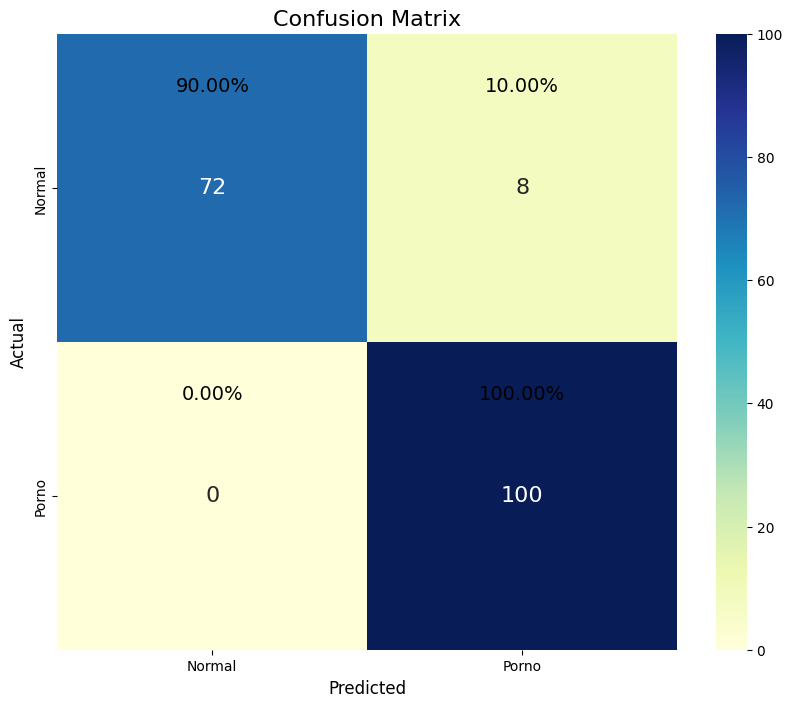

In [7]:
cm = confusion_matrix(trueLabels, predictions)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(trueLabels, predictions, digits=4)
print("Classification Report:\n", cr)

# Calculate accuracy score
accuracy = accuracy_score(trueLabels, predictions)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(trueLabels, predictions)
print("F1 Score:", format(f1, '.4f'))

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [75]:
predictions,trueLabels=test_videos_pourcentage(r'A:\AI DB\LSPD\Videos\normal_final',r'A:\AI DB\LSPD\Videos\porn_final',model_best,percentage=0.04)

Processed 159/160 videos (99.38%)
        Processing frame 4400/4344 (101.29%)
Total time: 16.89 seconds.


Classification Report:
               precision    recall  f1-score   support

           0     0.9825    0.7000    0.8175        80
           1     0.7670    0.9875    0.8634        80

    accuracy                         0.8438       160
   macro avg     0.8747    0.8438    0.8405       160
weighted avg     0.8747    0.8438    0.8405       160

Accuracy Score: 0.8438
F1 Score: 0.8634


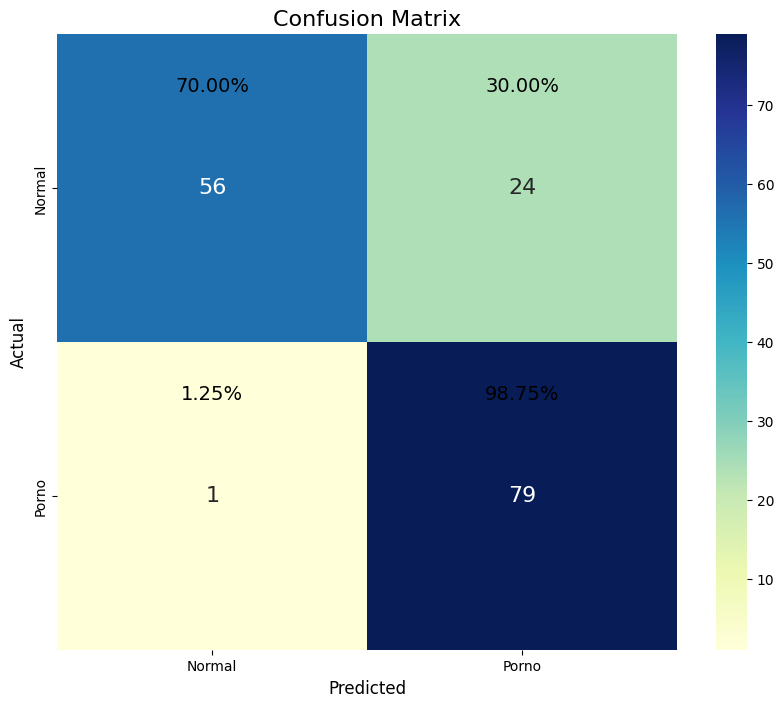

In [76]:
cm = confusion_matrix(trueLabels, predictions)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(trueLabels, predictions, digits=4)
print("Classification Report:\n", cr)

# Calculate accuracy score
accuracy = accuracy_score(trueLabels, predictions)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(trueLabels, predictions)
print("F1 Score:", format(f1, '.4f'))

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [10]:
predictions,trueLabels=test_videos_pourcentage(r'A:\AI DB\NPDI-2K\original\nonPorn',r'A:\AI DB\NPDI-2K\original\porn',
                                               model_best,
                                               sensibility=0.9,
                                               percentage=0.1)

Processed 200/200 videos (100.00%)
Videos with mismatched results:
Video: vNonPorn000824.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000667.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000272.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000357.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000219.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000767.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000294.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000307.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000671.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000335.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000653.mp4, Predicted: 1, True Label: 0
Video: vNonPorn000206.mp4, Predicted: 1, True Label: 0
Video: vPorn000440.mp4, Predicted: 0, True Label: 1
Video: vPorn000409.mp4, Predicted: 0, True Label: 1
Video: vPorn000952.mp4, Predicted: 0, True Label: 1
Video: vPorn000912.mp4, Predicted: 0, True Label: 1
Video: vPorn000880.mp4, Predicted: 0, True Label: 1
Total time: 5

Classification Report:
               precision    recall  f1-score   support

           0     0.9462    0.8800    0.9119       100
           1     0.8879    0.9500    0.9179       100

    accuracy                         0.9150       200
   macro avg     0.9170    0.9150    0.9149       200
weighted avg     0.9170    0.9150    0.9149       200

Accuracy Score: 0.9150
F1 Score: 0.9179


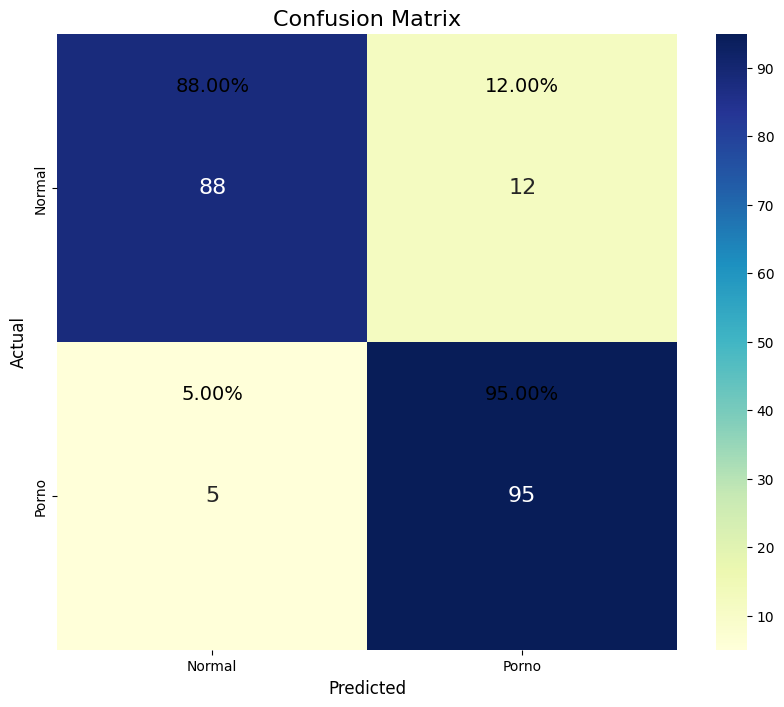

In [11]:
cm = confusion_matrix(trueLabels, predictions)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(trueLabels, predictions, digits=4)
print("Classification Report:\n", cr)

# Calculate accuracy score
accuracy = accuracy_score(trueLabels, predictions)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(trueLabels, predictions)
print("F1 Score:", format(f1, '.4f'))

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [12]:
predictionsLSPD,trueLabelsLSPD=test_videos_pourcentage(r'A:\AI DB\LSPD\Videos\normal_final',r'A:\AI DB\LSPD\Videos\porn_final',
                                               model_best,
                                               sensibility=0.9,
                                               percentage=0.04)

Processed 160/160 videos (100.00%)
Videos with mismatched results:
Video: nonporn_548.mp4, Predicted: 1, True Label: 0
Video: nonporn_543.mp4, Predicted: 1, True Label: 0
Video: nonporn_375.mp4, Predicted: 1, True Label: 0
Video: nonporn_633.mp4, Predicted: 1, True Label: 0
Video: nonporn_1033.mp4, Predicted: 1, True Label: 0
Video: nonporn_284.mp4, Predicted: 1, True Label: 0
Video: nonporn_63.mp4, Predicted: 1, True Label: 0
Video: nonporn_1581.mp4, Predicted: 1, True Label: 0
Video: nonporn_30.mp4, Predicted: 1, True Label: 0
Video: nonporn_1008.mp4, Predicted: 1, True Label: 0
Video: nonporn_1420.mp4, Predicted: 1, True Label: 0
Video: nonporn_11.mp4, Predicted: 1, True Label: 0
Video: nonporn_1128.mp4, Predicted: 1, True Label: 0
Video: nonporn_252.mp4, Predicted: 1, True Label: 0
Video: porn_976.mp4, Predicted: 0, True Label: 1
Video: porn_157.mp4, Predicted: 0, True Label: 1
Video: porn_1773.mp4, Predicted: 0, True Label: 1
Video: porn_723.mp4, Predicted: 0, True Label: 1
Video:

Classification Report:
               precision    recall  f1-score   support

           0     0.9296    0.8250    0.8742        80
           1     0.8427    0.9375    0.8876        80

    accuracy                         0.8812       160
   macro avg     0.8861    0.8812    0.8809       160
weighted avg     0.8861    0.8812    0.8809       160

Accuracy Score: 0.8812
F1 Score: 0.8876


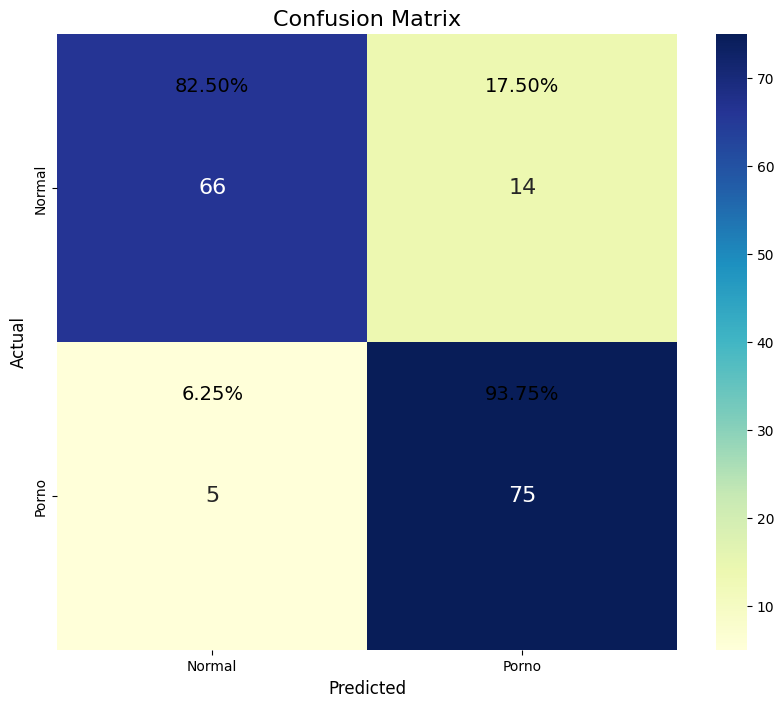

In [13]:
cm = confusion_matrix(trueLabelsLSPD, predictionsLSPD)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(trueLabelsLSPD, predictionsLSPD, digits=4)
print("Classification Report:\n", cr)

# Calculate accuracy score
accuracy = accuracy_score(trueLabelsLSPD, predictionsLSPD)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(trueLabelsLSPD, predictionsLSPD)
print("F1 Score:", format(f1, '.4f'))

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.7000    0.8235        40
           1     0.7692    1.0000    0.8696        40

    accuracy                         0.8500        80
   macro avg     0.8846    0.8500    0.8465        80
weighted avg     0.8846    0.8500    0.8465        80

Accuracy Score: 0.8500
F1 Score: 0.8696


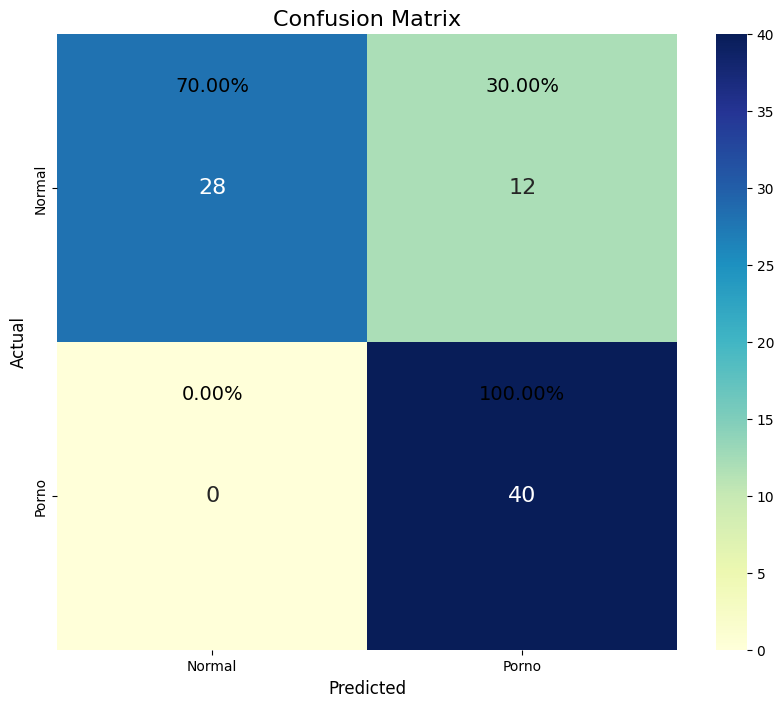

In [79]:
cm = confusion_matrix(trueLabels, predictions)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(trueLabels, predictions, digits=4)
print("Classification Report:\n", cr)

# Calculate accuracy score
accuracy = accuracy_score(trueLabels, predictions)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(trueLabels, predictions)
print("F1 Score:", format(f1, '.4f'))

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [6]:
def detect_porn(video_path, model, interval=1, sensibility=0.5700000000000001):
    # Open the video file
    video_capture = cv2.VideoCapture(video_path)
    
    # Get the frame rate of the video
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    
    # Calculate the frame interval based on the desired interval
    frame_interval = int(fps * interval)
    
    # Initialize a variable to keep track of the frame number
    frame_count = 0
    
    # Loop through the video frames
    while video_capture.isOpened():
        # Skip frames according to the interval
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
        
        # Read the next frame
        ret, frame = video_capture.read()
        
        # Check if the frame was read successfully
        if not ret:
            break

        processed_frame = preprocess_frame(frame)
        
        # Classify the frame using the model
        # Replace this line with your actual classification code
        is_porn = image_model.predict(processed_frame, verbose=0)
        
        # If pornographic content is detected, return 1
        if is_porn >= sensibility:
            video_capture.release()
            return 1
        
        # Increment the frame count by the interval
        frame_count += frame_interval
    
    # Release the video capture object
    video_capture.release()
    
    # If no pornographic content is detected, return 0
    return 0

In [7]:
def create_labels(directory, label):
    labels = []
    for filename in os.listdir(directory):
        labels.append(label)
    return labels

In [9]:
# Create labels for pornographic videos
porn_labels = create_labels(porn_video_directory, 1)

# Create labels for normal videos
normal_labels = create_labels(normal_video_directory, 0)

# Combine labels
all_labels = np.concatenate((porn_labels, normal_labels))
print("Labels:", all_labels)
print("Size : ",len(all_labels))

Labels: [1 1 1 ... 0 0 0]
Size :  4000


In [24]:
def testing(model, porn_directory, normal_directory, sensibility, percentage=0.10, random_seed=42):
    start_time = time.time()
    # Set the random seed for reproducibility
    np.random.seed(random_seed)
    
    # Get list of video files
    porn_videos = []
    normal_videos = []
    
    if porn_directory is not None:
        porn_videos = [filename for filename in os.listdir(porn_directory) if filename.endswith(".mp4")]
    
    if normal_directory is not None:
        normal_videos = [filename for filename in os.listdir(normal_directory) if filename.endswith(".mp4")]

    # Determine the number of videos to test based on the given percentage
    num_porn_videos_to_test = int(len(porn_videos) * percentage)
    num_normal_videos_to_test = int(len(normal_videos) * percentage)
    
    # Ensure equal number of porn and normal videos for balance (50% each)
    num_videos_to_test = min(num_porn_videos_to_test, num_normal_videos_to_test)
    
    # Randomly select videos to test
    porn_videos_to_test = np.random.choice(porn_videos, num_videos_to_test, replace=False) if num_porn_videos_to_test > 0 else []
    normal_videos_to_test = np.random.choice(normal_videos, num_videos_to_test, replace=False) if num_normal_videos_to_test > 0 else []
    
    all_videos_to_test = np.concatenate((porn_videos_to_test, normal_videos_to_test))
    all_predictions = []
    true_labels = []

    total_videos = len(all_videos_to_test)
    
    for idx, video in enumerate(all_videos_to_test):
        video_path = os.path.join(porn_directory, video) if video in porn_videos_to_test else os.path.join(normal_directory, video)
        
        # Print progress with current video name
        sys.stdout.write(f'\rProcessing video {idx + 1}/{total_videos} ({(idx + 1) / total_videos * 100:.2f}%): {video}')
        sys.stdout.flush()
        
        if video in porn_videos_to_test:
            true_labels.append(1)  # Porn video
        else:
            true_labels.append(0)  # Normal video
        
        prediction = detect_porn(video_path, model, sensibility)  # Assuming image_model is defined
        all_predictions.append(prediction)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print()  # Move to the next line after the progress indicator is done
    print(f"Processed {total_videos} videos in {elapsed_time:.2f} seconds.")
    
    return all_predictions, true_labels

In [29]:
predictions,trueLabels=testing(model_best,r'A:\AI DB\LSPD\Videos\test\porn',r'A:\AI DB\LSPD\Videos\test\safe-easy', sensibility=0.5, percentage=1, random_seed=40)

Processing video 62/62 (100.00%): nonporn_478.mp4
Processed 62 videos in 618.00 seconds.


Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.5484    0.7083        31
           1     0.6889    1.0000    0.8158        31

    accuracy                         0.7742        62
   macro avg     0.8444    0.7742    0.7621        62
weighted avg     0.8444    0.7742    0.7621        62

Accuracy Score: 0.7742
F1 Score: 0.8158


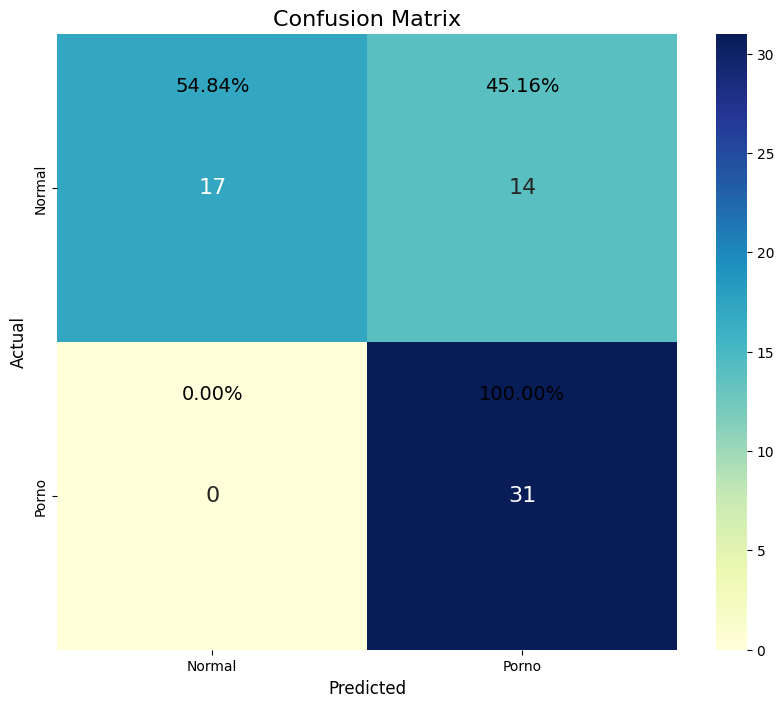

In [31]:
cm = confusion_matrix(trueLabels, predictions)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(trueLabels, predictions, digits=4)
print("Classification Report:\n", cr)

# Calculate accuracy score
accuracy = accuracy_score(trueLabels, predictions)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(trueLabels, predictions)
print("F1 Score:", format(f1, '.4f'))

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [18]:
prediction_05,trueLabels05=testing(porn_video_directory,normal_video_directory, sensibility=0.5, percentage=0.04, random_seed=40)

Processing video 80/80 (100.00%): vNonPorn000393.mp4
Processed 80 videos in 2826.54 seconds.


Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.1750    0.2979        40
           1     0.5479    1.0000    0.7080        40

    accuracy                         0.5875        80
   macro avg     0.7740    0.5875    0.5029        80
weighted avg     0.7740    0.5875    0.5029        80

Accuracy Score: 0.5875
F1 Score: 0.7080


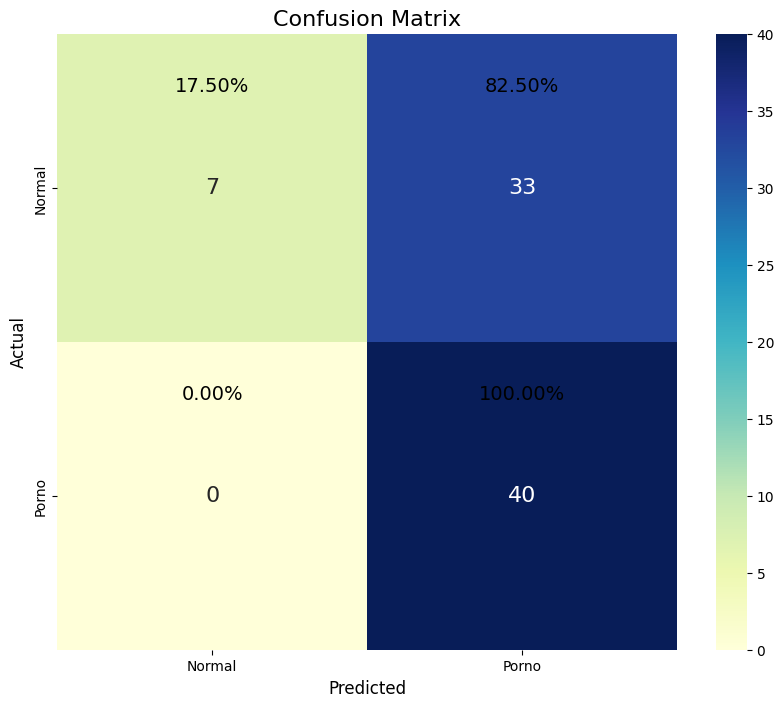

In [19]:
cm = confusion_matrix(trueLabels05, prediction_05)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(trueLabels05, prediction_05, digits=4)
print("Classification Report:\n", cr)

# Calculate accuracy score
accuracy = accuracy_score(trueLabels05, prediction_05)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(trueLabels05, prediction_05)
print("F1 Score:", format(f1, '.4f'))

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [20]:
prediction_09,trueLabels09=testing(porn_video_directory,normal_video_directory, sensibility=0.9, percentage=0.04, random_seed=40)

Processing video 63/80 (78.75%): vNonPorn000776.mp4

KeyboardInterrupt: 

In [ ]:
cm = confusion_matrix(trueLabels09, prediction_09)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(trueLabels09, prediction_09, digits=4)
print("Classification Report:\n", cr)

# Calculate accuracy score
accuracy = accuracy_score(trueLabels09, prediction_09)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(trueLabels09, prediction_09)
print("F1 Score:", format(f1, '.4f'))

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [12]:
test_dir = r'A:\AI DB\NudeNet\Nouveau dossier'

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    shuffle=False,                                          
    seed=10,
    class_mode='binary'
)

Found 7928 images belonging to 2 classes.


In [14]:
ypred = model_best.predict(test_generator)

248/248 [==============================] - 44s 166ms/step


Classification Report:
               precision    recall  f1-score   support

           0     0.8350    0.7533    0.7921      4050
           1     0.7663    0.8445    0.8035      3878

    accuracy                         0.7979      7928
   macro avg     0.8006    0.7989    0.7978      7928
weighted avg     0.8014    0.7979    0.7976      7928

Accuracy Score: 0.7979
F1 Score: 0.8035


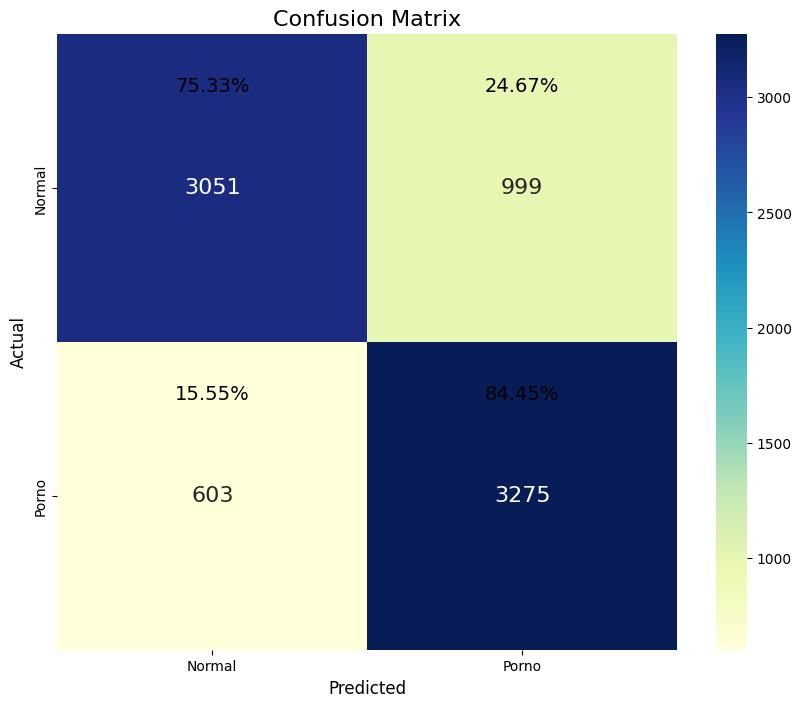

In [15]:
y_pred_classes = (ypred > 0.5700000000000001).astype(int)
y_true_classes = test_generator.classes

cm = confusion_matrix(y_true_classes, y_pred_classes)


# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(y_true_classes, y_pred_classes, digits=4)
print("Classification Report:\n", cr)

# Calculate accuracy score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(y_true_classes, y_pred_classes)
print("F1 Score:", format(f1, '.4f'))

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()